# <a id='toc1_'></a>[Figures](#toc0_)

**Table of contents**<a id='toc0_'></a>    
- [Figures](#toc1_)    
  - [Functions used to simulate the magnetic field](#toc1_1_)    
  - [Accuracy results](#toc1_2_)    
  - [Weights analysis](#toc1_3_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [23]:
import torch
import matplotlib.pyplot as plt 
import os
import datetime
from matplotlib.ticker import AutoMinorLocator
FOLDER = 'figures'
SIMULATION_FOLDER = 'simulations'
GRAPHS_ID = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
graph_folder = os.path.join(FOLDER, GRAPHS_ID)
os.makedirs(graph_folder, exist_ok=True)

## <a id='toc1_1_'></a>[Functions used to simulate the magnetic field](#toc0_)

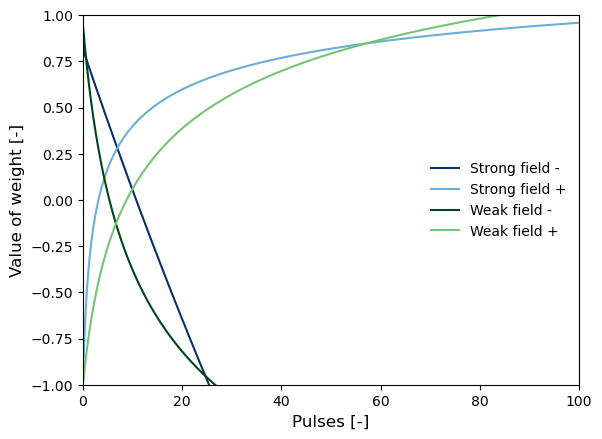

In [24]:
scale = 1
f_strong_minus = lambda x: scale * (2*(-24.77 * \
                torch.log(0.287*torch.log(x+128))+9.11)-1)
f_strong_plus = lambda x: scale * (2*(0.443 * \
                torch.log(2.53*torch.log(x+1.66)) - 0.11)-1)

f_weak_minus = lambda x: scale * \
                (-2.56*torch.log(0.997*torch.log(x+5.02)) + 2.166)
f_weak_plus = lambda x: scale * \
                (1.8132 * torch.log(1.176*torch.log(x+4.42))-2.014)
# plot all functions
fig, ax = plt.subplots()
x = torch.linspace(0, 100, 1000)
shades_blue = plt.get_cmap('Blues_r', 3)
shades_green = plt.get_cmap('Greens_r', 3)
ax.plot(x, f_strong_minus(x), label="Strong field -", color=shades_blue(0))
ax.plot(x, f_strong_plus(x), label="Strong field +", color=shades_blue(1))
ax.plot(x, f_weak_minus(x), label="Weak field -", color=shades_green(0))
ax.plot(x, f_weak_plus(x), label="Weak field +", color=shades_green(1))
ax.legend(loc='center right', fontsize=10, frameon=False)
ax.set_xlabel("Pulses [-]", fontsize=12)
ax.set_ylabel("Value of weight [-]", fontsize=12)
# export
name = "weight-evolution-" + GRAPHS_ID
ax.set_ylim(-scale, scale)
ax.set_xlim(0, 100)
fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')
fig.savefig(f"{graph_folder}/{name}.svg", bbox_inches='tight')

## <a id='toc1_2_'></a>[Accuracy results](#toc0_)

The data is loaded from the simulation path and the data is saved and displayed.

In [25]:
n_iterations = 10
paths = [
    "20240711164919-MNIST-weak-0.5-switch-None", # Strong field - LR 0.01
    "20240711165306-MNIST-strong-0.5-switch-None", # Weak field - LR 0.01
    "20240711165851-MNIST-linear-0.5-switch-None", # Linear field - LR 0.01
    "20240711170941-MNIST-strong-weak-0.5-switch-2",
]
models = []
for path in paths:
    # first dim of the tensor is the iteration
    accuracies = []
    for it in range(n_iterations):
        current_folder = os.path.join(SIMULATION_FOLDER, path)
        accuracies.append(torch.load(os.path.join(current_folder, path+f"-{it}-accuracies.pth")))
    accuracies = torch.stack(accuracies)
    models.append(accuracies)
models = torch.stack(models)

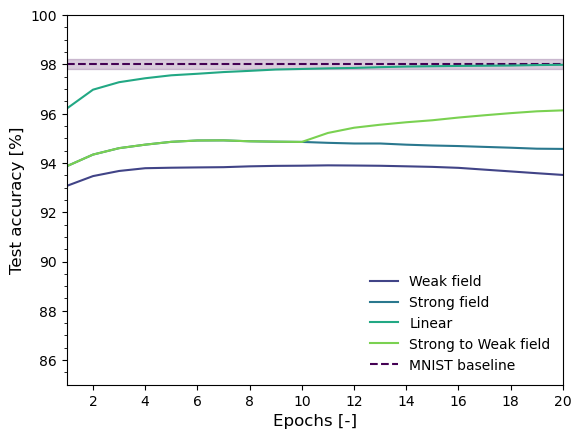

In [26]:
fig, ax = plt.subplots()
palette = plt.get_cmap('viridis', len(models)+2)
# Add mnist baseline 98% +- 0.2% for 512 hidden units
ax.hlines(98, 1, 20, color=palette(0), linestyle='--', label="MNIST baseline")
ax.fill_between([1, 20], 97.8, 98.2, alpha=0.2, color=palette(0))
# compare models
names = ["Weak field", "Strong field",  "Linear", "Strong to Weak field"] 
for i, model in enumerate(models):
    mean = torch.mean(model, dim=0)
    std = torch.std(model, dim=0)
    # add one element to the beginning of the tensor
    mean = torch.cat((torch.tensor([0.0]), mean))
    std = torch.cat((torch.tensor([0.0]), std))
    ax.plot(mean*100, label=f"{names[i]}", color=palette(i+1))
    ax.fill_between(mean - std, mean + std, alpha=0.2, color=palette(i+1))

ax.set_xlabel("Epochs [-]", fontsize=12)
ax.set_ylabel("Test accuracy [%]", fontsize=12)
ax.legend(loc='lower right', fontsize=10, frameon=False)
ax.yaxis.set_minor_locator(AutoMinorLocator())
ax.set_ylim([85, 100])
ax.set_xticks(range(0, 21,2))
ax.set_xlim([1, 20])
plt.show()
# save as pdf and svg
name = "weak-vs-strong-" + GRAPHS_ID
fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')
fig.savefig(f"{graph_folder}/{name}.svg", bbox_inches='tight')
    

## <a id='toc1_3_'></a>[Weights analysis](#toc0_)

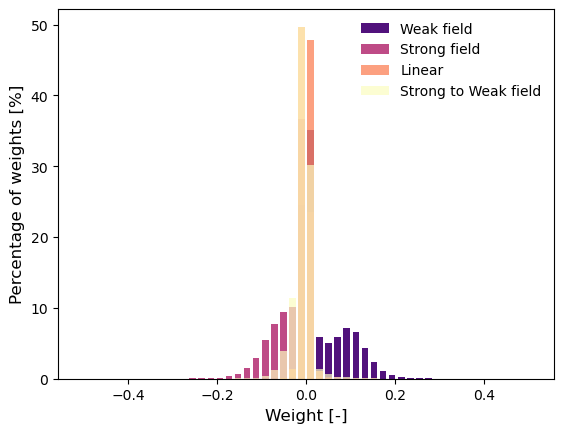

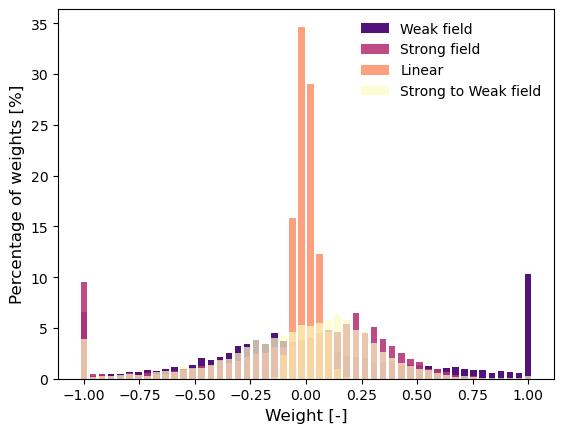

In [36]:
models = []
for path in paths:
    # first dim of the tensor is the iteration
    accuracies = []
    current_folder = os.path.join(SIMULATION_FOLDER, path)
    accuracies.append(torch.load(os.path.join(current_folder, path+f"-0.pth")))
    models.append(accuracies)
thresholds = [0.5, 1]
# weights keys (layers.1.weght)
keys = ["layers.1.weight", "layers.4.weight"]
for k, key in enumerate(keys):
    fig, ax = plt.subplots()
    palette = plt.get_cmap('magma', len(models)+1)
    # compare models
    names = ["Weak field", "Strong field", "Linear", "Strong to Weak field"]
    for i, model in enumerate(models):
        weights = model[0][key].flatten()
        hist = torch.histc(weights, bins=50, min=-thresholds[k], max=thresholds[k]).to('cpu')
        # plot in % of the total weights
        ax.bar(torch.linspace(-thresholds[k], thresholds[k], 50), height=hist/len(weights)*100, width=0.03*thresholds[k], label=f"{names[i]}", color=palette(i+1), alpha=(1-0.1*i))
    ax.set_xlabel("Weight [-]", fontsize=12)
    ax.set_ylabel("Percentage of weights [%]", fontsize=12)
    ax.legend(loc='upper right', fontsize=10, frameon=False)
    # save
    name = f"MNIST-weight-distribution-{key}-{GRAPHS_ID}"
    fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')
    fig.savefig(f"{graph_folder}/{name}.svg", bbox_inches='tight')
    plt.show()

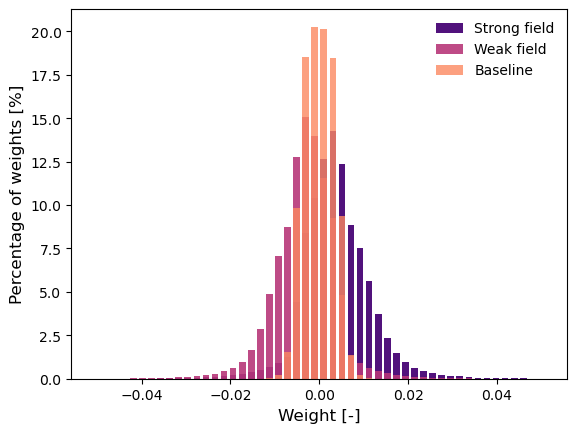

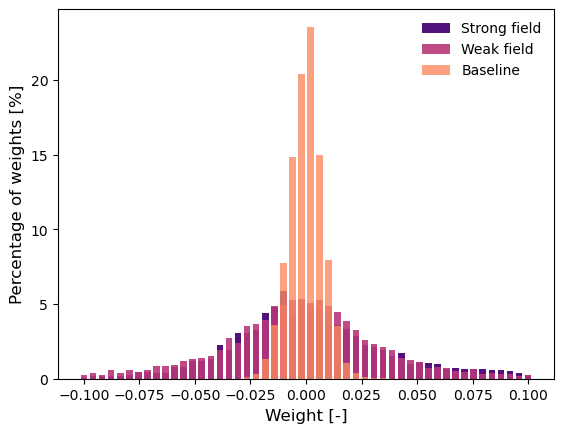

In [ ]:
models = []
paths = [
    "20240711090043-Fashion-weak-0.1", # Strong field - LR 0.01
    "20240711090122-Fashion-strong-0.1", # Weak field - LR 0.01
    "20240711090508-Fashion-linear-0.001", # Linear field - LR 0.01
]
for path in paths:
    # first dim of the tensor is the iteration
    accuracies = []
    current_folder = os.path.join(SIMULATION_FOLDER, path)
    accuracies.append(torch.load(os.path.join(current_folder, path+f"-0.pth")))
    models.append(accuracies)
thresholds = [0.05, 0.1]
# weights keys (layers.1.weght)
keys = ["layers.1.weight", "layers.4.weight"]
for k, key in enumerate(keys):
    fig, ax = plt.subplots()
    palette = plt.get_cmap('magma', len(models)+2)
    # compare models
    names = ["Strong field", "Weak field", "Baseline"]
    for i, model in enumerate(models):
        weights = model[0][key].flatten()
        hist = torch.histc(weights, bins=50, min=-thresholds[k], max=thresholds[k]).to('cpu')
        # plot in % of the total weights
        ax.bar(torch.linspace(-thresholds[k], thresholds[k], 50), height=hist/len(weights)*100, width=0.03*thresholds[k], label=f"{names[i]}", color=palette(i+1), alpha=(1-0.1*i))
    ax.set_xlabel("Weight [-]", fontsize=12)
    ax.set_ylabel("Percentage of weights [%]", fontsize=12)
    ax.legend(loc='upper right', fontsize=10, frameon=False)
    name = f"FashionMNIST-weight-distribution-{key}-{GRAPHS_ID}"
    fig.savefig(f"{graph_folder}/{name}.pdf", bbox_inches='tight')
    fig.savefig(f"{graph_folder}/{name}.svg", bbox_inches='tight')
    plt.show()

In [ ]:
# get all paths with MNIST in simulations
paths = [f for f in os.listdir(SIMULATION_FOLDER) if "MNIST" in f]
models = []
for path in paths:
    # first dim of the tensor is the iteration
    accuracies = []
    for it in range(n_iterations):
        current_folder = os.path.join(SIMULATION_FOLDER, path)
        accuracies.append(torch.load(os.path.join(current_folder, path+f"-{it}-accuracies.pth")))
    accuracies = torch.stack(accuracies)
    models.append(accuracies)
models = torch.stack(models)
for path, model in zip(paths, models):
    # if any of 0.5, 0.1, 0.01 is in the path
    if not any([i in path for i in ["0.05", "0.1", "0.5", "1"]]):
        continue
    model = model * 100
    mean = f"{model.mean(dim=0)[-1].item():.2f}"
    std = f"{model.std(dim=0)[-1].item():.2f}"
    print(f"{mean} +- {std} - {path}")

94.60 +- 0.17 - 20240711165033-MNIST-weak-0.05-switch-None
94.63 +- 0.14 - 20240711165456-MNIST-strong-0.05-switch-None
97.97 +- 0.07 - 20240711170038-MNIST-linear-0.05-switch-None
95.88 +- 0.10 - 20240711170603-MNIST-weak-strong-0.05-switch-2
95.89 +- 0.11 - 20240711171135-MNIST-strong-weak-0.05-switch-2
94.60 +- 0.17 - 20240711171726-MNIST-weak-0.05-switch-4
94.63 +- 0.14 - 20240711172316-MNIST-strong-0.05-switch-4


In [41]:
paths = [f for f in os.listdir(SIMULATION_FOLDER) if "Fashion" in f]
models = []
for path in paths:
    # first dim of the tensor is the iteration
    accuracies = []
    for it in range(n_iterations):
        current_folder = os.path.join(SIMULATION_FOLDER, path)
        accuracies.append(torch.load(os.path.join(current_folder, path+f"-{it}-accuracies.pth")))
    accuracies = torch.stack(accuracies)
    models.append(accuracies)
models = torch.stack(models)
for path, model in zip(paths, models):
    # if any of 0.5, 0.1, 0.01 is in the path
    if not any([i in path for i in ["1.0"]]):
        continue
    model = model * 100
    mean = f"{model.mean(dim=0)[-1].item():.2f}"
    std = f"{model.std(dim=0)[-1].item():.2f}"
    print(f"{mean} +- {std} - {path}")
    

85.78 +- 0.15 - 20240712082402-Fashion-weak-1.0-switch-None
85.51 +- 0.15 - 20240712082755-Fashion-strong-1.0-switch-None
87.21 +- 0.35 - 20240712083151-Fashion-linear-1.0-switch-None
85.04 +- 0.17 - 20240712083514-Fashion-weak-strong-1.0-switch-2
85.91 +- 0.23 - 20240712083912-Fashion-strong-weak-1.0-switch-2
85.31 +- 0.14 - 20240712084743-Fashion-weak-strong-1.0-switch-4
84.62 +- 0.25 - 20240712085140-Fashion-strong-weak-1.0-switch-4
